# Deep Reinforcement Learning using AlphaZero methodology

Please see https://applied-data.science/blog/how-to-build-your-own-alphazero-ai-using-python-and-keras/ for further notes on the codebase

## 1. First load the core libraries

In [1]:
# -*- coding: utf-8 -*-
# %matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
np.set_printoptions(suppress=True)

from shutil import copyfile
import random
from importlib import reload


from keras.utils import plot_model

from game import Game, GameState
from agent import Agent
from memory import Memory
from model import Residual_CNN
from funcs import playMatches, playMatchesBetweenVersions

import loggers as lg

from settings import run_folder, run_archive_folder
import initialise
import pickle
import time

Using TensorFlow backend.


## 2. Now run this block to start the learning process

This block loops for ever, continually learning from new game data.

The current best model and memories are saved in the run folder so you can kill the process and restart from the last checkpoint.

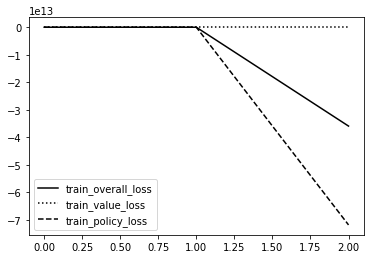

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



TOURNAMENT...
1 2 3 4 5 
SCORES
{'best_player': 5, 'drawn': 0, 'current_player': 0}

STARTING PLAYER / NON-STARTING PLAYER SCORES
{'sp': 3, 'drawn': 0, 'nsp': 2}



ITERATION NUMBER 2
BEST PLAYER VERSION 0
SELF PLAYING 5 EPISODES...
1 2 3 4 

In [ ]:
lg.logger_main.info('=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*')
lg.logger_main.info('=*=*=*=*=*=.      NEW LOG      =*=*=*=*=*')
lg.logger_main.info('=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*')

env = Game()

# If loading an existing neural network, copy the config file to root
if initialise.INITIAL_RUN_NUMBER != None:
    copyfile(run_archive_folder + '/run' + str(initialise.INITIAL_RUN_NUMBER).zfill(4) + '/config.py', './config.py')

import config

######## LOAD MEMORIES IF NECESSARY ########

if initialise.INITIAL_MEMORY_VERSION == None:
    memory = Memory(config.MEMORY_SIZE)
else:
    print('LOADING MEMORY VERSION ' + str(initialise.INITIAL_MEMORY_VERSION) + '...')
    memory = pickle.load( open( run_archive_folder + '/run' + str(initialise.INITIAL_RUN_NUMBER).zfill(4) + "/memory/memory" + str(initialise.INITIAL_MEMORY_VERSION).zfill(4) + ".p",   "rb" ) )

######## LOAD MODEL IF NECESSARY ########

# create an untrained neural network objects from the config file
current_NN = Residual_CNN(config.REG_CONST, config.LEARNING_RATE, (2,) + env.grid_shape,   env.action_size, config.HIDDEN_CNN_LAYERS)
best_NN = Residual_CNN(config.REG_CONST, config.LEARNING_RATE, (2,) +  env.grid_shape,   env.action_size, config.HIDDEN_CNN_LAYERS)

#If loading an existing neural netwrok, set the weights from that model
if initialise.INITIAL_MODEL_VERSION != None:
    best_player_version  = initialise.INITIAL_MODEL_VERSION
    print('LOADING MODEL VERSION ' + str(initialise.INITIAL_MODEL_VERSION) + '...')
    m_tmp = best_NN.read(env.name, initialise.INITIAL_RUN_NUMBER, best_player_version)
    current_NN.model.set_weights(m_tmp.get_weights())
    best_NN.model.set_weights(m_tmp.get_weights())
#otherwise just ensure the weights on the two players are the same
else:
    best_player_version = 0
    best_NN.model.set_weights(current_NN.model.get_weights())

#copy the config file to the run folder
copyfile('./config.py', run_folder + 'config.py')
plot_model(current_NN.model, to_file=run_folder + 'models/model.png', show_shapes = True)

print('\n')

######## CREATE THE PLAYERS ########

current_player = Agent('current_player', env.state_size, env.action_size, config.MCTS_SIMS, config.CPUCT, current_NN)
best_player = Agent('best_player', env.state_size, env.action_size, config.MCTS_SIMS, config.CPUCT, best_NN)
#user_player = User('player1', env.state_size, env.action_size)
iteration = 0
start_time = time.time()
for infi in range(10):

    iteration += 1
    reload(lg)
    reload(config)

    print('ITERATION NUMBER ' + str(iteration))

    lg.logger_main.info('BEST PLAYER VERSION: %d', best_player_version)
    print('BEST PLAYER VERSION ' + str(best_player_version))

    ######## SELF PLAY ########
    print('SELF PLAYING ' + str(config.EPISODES) + ' EPISODES...')
    _, memory, _, _ = playMatches(best_player, best_player, config.EPISODES, lg.logger_main, turns_until_tau0 = config.TURNS_UNTIL_TAU0, memory = memory)
        
    print('\n')
    print(f'len(MEMORY.LTMEMORY): {len(memory.ltmemory)}')
    memory.clear_stmemory()
    #save memory if it bigger or each 10 minutes
    if len(memory.ltmemory) >= config.MEMORY_SIZE or ((time.time()-start_time)/60) > 30:
        start_time = time.time()
        ######## RETRAINING ########
        print('RETRAINING...')
        current_player.replay(memory.ltmemory)
        print('')

#         if iteration % 2 == 0:
        pickle.dump( memory, open( run_folder + "memory/memory" + str(iteration).zfill(4) + ".p", "wb" ) )

        lg.logger_memory.info('====================')
        lg.logger_memory.info('NEW MEMORIES')
        lg.logger_memory.info('====================')

        memory_samp = random.sample(memory.ltmemory, min(1000, len(memory.ltmemory)))

        for s in memory_samp:
            current_value, current_probs, _ = current_player.get_preds(s['state'])
            best_value, best_probs, _ = best_player.get_preds(s['state'])

            lg.logger_memory.info('MCTS VALUE FOR %s: %f', s['playerTurn'], s['value'])
            lg.logger_memory.info('CUR PRED VALUE FOR %s: %f', s['playerTurn'], current_value)
            lg.logger_memory.info('BES PRED VALUE FOR %s: %f', s['playerTurn'], best_value)
            lg.logger_memory.info('THE MCTS ACTION VALUES: %s', ['%.2f' % elem for elem in s['AV']]  )
            lg.logger_memory.info('CUR PRED ACTION VALUES: %s', ['%.2f' % elem for elem in  current_probs])
            lg.logger_memory.info('BES PRED ACTION VALUES: %s', ['%.2f' % elem for elem in  best_probs])
            lg.logger_memory.info('ID: %s', s['state'].id)
            lg.logger_memory.info('INPUT TO MODEL: %s', current_player.model.convertToModelInput(s['state']))

            s['state'].render(lg.logger_memory)

        ######## TOURNAMENT ########
        print('TOURNAMENT...')
        scores, _, points, sp_scores = playMatches(best_player, current_player, config.EVAL_EPISODES, lg.logger_tourney, turns_until_tau0 = 0, memory = None)
        print('\nSCORES')
        print(scores)
        print('\nSTARTING PLAYER / NON-STARTING PLAYER SCORES')
        print(sp_scores)
        #print(points)

        print('\n\n')

        if scores['current_player'] > scores['best_player'] * config.SCORING_THRESHOLD:
            best_player_version = best_player_version + 1
            best_NN.model.set_weights(current_NN.model.get_weights())
            best_NN.write(env.name, best_player_version)

    else:
        print('MEMORY SIZE: ' + str(len(memory.ltmemory)))

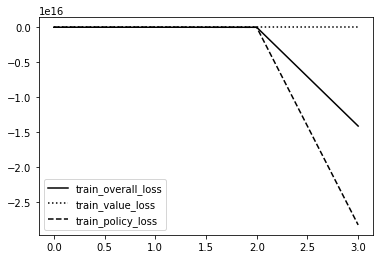

PicklingError: Can't pickle <class 'game.GameState'>: it's not the same object as game.GameState

<Figure size 432x288 with 0 Axes>

In [6]:
start_time = time.time()
######## RETRAINING ########
print('RETRAINING...')
current_player.replay(memory.ltmemory)
print('')

#         if iteration % 2 == 0:
pickle.dump( memory, open( run_folder + "memory/memory" + str(iteration).zfill(4) + ".p", "wb" ) )

lg.logger_memory.info('====================')
lg.logger_memory.info('NEW MEMORIES')
lg.logger_memory.info('====================')

memory_samp = random.sample(memory.ltmemory, min(1000, len(memory.ltmemory)))

for s in memory_samp:
    current_value, current_probs, _ = current_player.get_preds(s['state'])
    best_value, best_probs, _ = best_player.get_preds(s['state'])

    lg.logger_memory.info('MCTS VALUE FOR %s: %f', s['playerTurn'], s['value'])
    lg.logger_memory.info('CUR PRED VALUE FOR %s: %f', s['playerTurn'], current_value)
    lg.logger_memory.info('BES PRED VALUE FOR %s: %f', s['playerTurn'], best_value)
    lg.logger_memory.info('THE MCTS ACTION VALUES: %s', ['%.2f' % elem for elem in s['AV']]  )
    lg.logger_memory.info('CUR PRED ACTION VALUES: %s', ['%.2f' % elem for elem in  current_probs])
    lg.logger_memory.info('BES PRED ACTION VALUES: %s', ['%.2f' % elem for elem in  best_probs])
    lg.logger_memory.info('ID: %s', s['state'].id)
    lg.logger_memory.info('INPUT TO MODEL: %s', current_player.model.convertToModelInput(s['state']))

    s['state'].render(lg.logger_memory)

######## TOURNAMENT ########
print('TOURNAMENT...')
scores, _, points, sp_scores = playMatches(best_player, current_player, config.EVAL_EPISODES, lg.logger_tourney, turns_until_tau0 = 0, memory = None)
print('\nSCORES')
print(scores)
print('\nSTARTING PLAYER / NON-STARTING PLAYER SCORES')
print(sp_scores)
#print(points)

print('\n\n')

if scores['current_player'] > scores['best_player'] * config.SCORING_THRESHOLD:
    best_player_version = best_player_version + 1
    best_NN.model.set_weights(current_NN.model.get_weights())
    best_NN.write(env.name, best_player_version)


In [16]:
gs = GameState(test_board, 1)
np.random.choice(gs.allowedActions)

28

## The following panels are not involved in the learning process

### Play matches between versions (use -1 for human player)

In [ ]:
from game import *
from funcs import playMatchesBetweenVersions
import loggers as lg


playMatchesBetweenVersions(env, 1, 0, 0, 5, lg.logger_tourney, 0)

### Pass a particular game state through the neural network (setup below for Connect4)

In [9]:
from game import *
BOARD_SIZE = 9
test_board = np.array([0 for i in range(BOARD_SIZE*BOARD_SIZE)])
test_board[19] = 1
test_board[20] = 1
test_board[21] = 1
test_board[22] = -1
test_board[30] = -1
test_board[38] = -1
test_board[45] = -1
print(test_board)
env = Game(BOARD_SIZE)

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1 -1  0
  0  0  0  0  0  0 -1  0  0  0  0  0  0  0 -1  0  0  0  0  0  0 -1  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0]


In [ ]:
best_player_version

In [23]:
# from agent import User
# from game import *
# test_board = np.array([0 for i in range(BOARD_SIZE*BOARD_SIZE)])
# test_board[19] = 1
# test_board[20] = 1
# test_board[21] = 1
# test_board[22] = -1
# test_board[30] = -1
# test_board[38] = -1
# test_board[45] = -1
# print(test_board)
# env = Game()
# user = User('real_player', env.state_size, env.action_size)
# ai = current_player
# gs = GameState(test_board, 1)

# env.gameState = gs
# for r in range(BOARD_SIZE):
#         print([env.pieces[str(x)] for x in gs.board[BOARD_SIZE*r : (BOARD_SIZE*r + BOARD_SIZE)]])
# print(f'player turn: {gs.playerTurn}')
# action, pi, MCTS_value, NN_value = ai.act(gs, 0)
# # preds = ai.get_preds(gs)
# state, value, done, _ = test_game.step(action)
# for r in range(BOARD_SIZE):
#         print([env.pieces[str(x)] for x in state.board[BOARD_SIZE*r : (BOARD_SIZE*r + BOARD_SIZE)]])
# # for r in range(BOARD_SIZE):
# #         print(['----' if x == 0 else '{0:.2f}'.format(x)
# #                for x in 
# #                preds[1][BOARD_SIZE*r : (BOARD_SIZE*r + BOARD_SIZE)]])
        
# # print(preds) 
# print(f'player turn: {state.playerTurn}')
# state, value, done, _ = test_game.step(14)
# test_game.gameState = gs
# for r in range(BOARD_SIZE):
#         print([env.pieces[str(x)] for x in gs.board[BOARD_SIZE*r : (BOARD_SIZE*r + BOARD_SIZE)]])
# print()
# action, pi, MCTS_value, NN_value = ai.act(gs, 0)
# # preds = ai.get_preds(gs)
# state, value, done, _ = test_game.step(action)
# for r in range(BOARD_SIZE):
#         print([env.pieces[str(x)] for x in state.board[BOARD_SIZE*r : (BOARD_SIZE*r + BOARD_SIZE)]])

In [13]:

# from agent import User
# # test_game
# run_version=0
# player1version=-1
# player2version=0
# EPISODES=1
# turns_until_tau0=config.TURNS_UNTIL_TAU0
# env = Game()
# env.gameState = GameState(test_board, 1)
# memory = None
# goes_first = 1
# # scores, memory, points, sp_scores = playMatchesBetweenVersions(test_game, run_version,player1version,player2version,test_episodes,test_logger,turns_until_tau0)

In [ ]:
# env.reset().board

In [30]:
from agent import User
from game import *
test_board = np.array([0 for i in range(BOARD_SIZE*BOARD_SIZE)])
test_board[19] = 1
test_board[20] = 1
test_board[21] = 1
test_board[22] = -1
test_board[30] = -1
test_board[38] = -1
test_board[45] = -1
# print(test_board)
env = Game()
player1 = User('player1', env.state_size, env.action_size)
player2 = current_player
env.gameState = GameState(test_board, 1)
scores = {player1.name:0, "drawn": 0, player2.name:0}
sp_scores = {'sp':0, "drawn": 0, 'nsp':0}
points = {player1.name:[], player2.name:[]}
state = env.gameState

#     state = env.reset()
turns_until_tau0 = config.TURNS_UNTIL_TAU0
goes_first = 1
done = 0
turn = 0
player1.mcts = None
player2.mcts = None

if goes_first == 0:
    player1Starts = random.randint(0,1) * 2 - 1
else:
    player1Starts = goes_first

if player1Starts == 1:
    players = {1:{"agent": player1, "name":player1.name}
            , -1: {"agent": player2, "name":player2.name}
            }
    print(player1.name + ' plays as X')
else:
    players = {1:{"agent": player2, "name":player2.name}
            , -1: {"agent": player1, "name":player1.name}
            }
    print(player2.name + ' plays as X')
    print('--------------')

for r in range(BOARD_SIZE):
    print([env.gameState.pieces[str(x)] for x in env.gameState.board[BOARD_SIZE*r : (BOARD_SIZE*r + BOARD_SIZE)]])
print('--------------')
while done == 0:
    turn = turn + 1

    #### Run the MCTS algo and return an action
    print(f'playerTurn: {state.playerTurn}')
    if turn < turns_until_tau0:
        action, pi, MCTS_value, NN_value = players[state.playerTurn]['agent'].act(state, 1)
    else:
        action, pi, MCTS_value, NN_value = players[state.playerTurn]['agent'].act(state, 0)

    if memory != None:
        ####Commit the move to memory
        memory.commit_stmemory(env.identities, state, pi)

    print('action: %d', action)

    ### Do the action
    state, value, done, _ = env.step(action) #the value of the newState from the POV of the new playerTurn i.e. -1 if the previous player played a winning move

    for r in range(BOARD_SIZE):
        print([env.gameState.pieces[str(x)] for x in env.gameState.board[BOARD_SIZE*r : (BOARD_SIZE*r + BOARD_SIZE)]])
    print('--------------')

    if done == 1: 
        if memory != None:
            #### If the game is finished, assign the values correctly to the game moves
            for move in memory.stmemory:
                if move['playerTurn'] == state.playerTurn:
                    move['value'] = value
                else:
                    move['value'] = -value

            memory.commit_ltmemory()

        if value == 1:
            print('%s WINS!', players[state.playerTurn]['name'])
#                 logger.info('game over')
#             print('len(stmemory): %s, len(ltmemory): %s', str(len(memory.stmemory)), str(len(memory.ltmemory)))
            scores[players[state.playerTurn]['name']] = scores[players[state.playerTurn]['name']] + 1
            if state.playerTurn == 1: 
                sp_scores['sp'] = sp_scores['sp'] + 1
            else:
                sp_scores['nsp'] = sp_scores['nsp'] + 1

        elif value == -1:
            print('%s WINS!', players[-state.playerTurn]['name'])
#             print('len(stmemory): %s, len(ltmemory): %s', str(len(memory.stmemory)), str(len(memory.ltmemory)))
            scores[players[-state.playerTurn]['name']] = scores[players[-state.playerTurn]['name']] + 1

            if state.playerTurn == 1: 
                sp_scores['nsp'] = sp_scores['nsp'] + 1
            else:
                sp_scores['sp'] = sp_scores['sp'] + 1

        else:
            print('DRAW...')
            scores['drawn'] = scores['drawn'] + 1
            sp_scores['drawn'] = sp_scores['drawn'] + 1

        pts = state.score
        points[players[state.playerTurn]['name']].append(pts[0])
        points[players[-state.playerTurn]['name']].append(pts[1])

player1 plays as X
['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', 'X', 'X', 'X', 'O', '-', '-', '-', '-', '-', '-', '-']
['O', '-', '-', '-', '-', '-', '-', '-', 'O', '-', '-', '-', '-', '-', '-']
['O', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-'

Enter your chosen action: 18
<class 'int'>
action: %d 18
['-', '-', 'O', '-', '-', '-', '-', '-', '-', '-', '-', '-', 'X', '-', '-']
['-', 'X', 'X', 'X', 'X', 'X', 'X', 'O', '-', '-', '-', '-', '-', '-', '-']
['O', '-', '-', '-', '-', '-', '-', '-', 'O', '-', '-', '-', 'O', '-', '-']
['O', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', 

### See the layers of the current neural network

In [ ]:
# current_player.model.viewLayers()

### Output a diagram of the neural network architecture

In [ ]:
from keras.utils import plot_model
plot_model(current_NN.model, to_file=run_folder + 'models/model.png', show_shapes = True)